In [ ]:
import os 

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir("/content/gdrive/MyDrive/DATA255/project")

In [ ]:
import pandas as pd
import numpy as np
import random

import re 
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, BatchNormalization, Bidirectional, GaussianNoise
from keras.layers import Reshape,  Concatenate, Dropout, SpatialDropout1D, SpatialDropout2D
from keras.layers import SimpleRNN, LSTM, GRU, Conv1D, Conv2D, Attention, MaxPooling1D, MaxPooling2D
from keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils import plot_model
from keras import backend as K
from keras.layers import Layer

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Load data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X_train, y_train = train['processed_text'].astype(str), train['label']
X_test, y_test = test['processed_text'].astype(str), test['label']

In [ ]:
X_train.head(3)

0    trump say would surprise iran compliant nuclea...
1    trump nominate robert jackson seat sec sourcew...
2    discover former pakistaniborn muslim aide inve...
Name: processed_text, dtype: object

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(78684,) (26228,)
(78684,) (26228,)


In [ ]:
def max_lenth():
    text_len = []
    for text in X_train:
        text_len.append(len(text))
    return int(np.ceil(np.mean(text_len)))

In [ ]:
# tokenize and Pad/Truncate Text

max_num_words = 10000
max_seq_length = 500

tokenizer = Tokenizer(num_words = max_num_words, lower=False)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_seq_length = max_lenth()

X_train = pad_sequences(X_train, maxlen = max_seq_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen = max_seq_length, padding='post', truncating='post')

total_words = len(tokenizer.word_index) + 1

print("Vocabulary Size :- ",total_words)
print('Encoded X Train\n', X_train, '\n')
print('Encoded X Test\n', X_test, '\n')
print('Maximum sequence length: ', max_seq_length)

Vocabulary Size :-  363005
Encoded X Train
 [[   2    1    4 ...    0    0    0]
 [   2 1595 1051 ...    0    0    0]
 [1360   64  563 ...  483  259  157]
 ...
 [6208  830  557 ...    0    0    0]
 [   7   94   13 ...    0    0    0]
 [ 216  540  149 ...   12  555  132]] 

Encoded X Test
 [[1214 8510    9 ...    0    0    0]
 [ 519 9058 8324 ...    0    0    0]
 [3610  609  311 ...  743  222 1192]
 ...
 [5026 2858 2205 ...    0    0    0]
 [2631  154  181 ...  338  201 1022]
 [  33  279 3539 ...  472 4190  232]] 

Maximum sequence length:  236


In [ ]:
def baseline_model():
        
    inputs = Input(shape = (max_seq_length, ))
    embedding = Embedding(10000, 300, trainable=False, input_length = max_seq_length)(inputs)
    rnn = SimpleRNN(32)(embedding)
    outputs = Dense(1,activation = 'sigmoid')(rnn)
    
    model = Model(inputs = inputs, outputs = outputs)
    opt = optimizers.Adam(lr=1e-3, decay = 1e-5)
    model.compile(loss = 'binary_crossentropy',optimizer = opt, metrics=['accuracy'])
    model.summary()
    
    return model
    
baseline = baseline_model()

filepath = './models/Baseline_RNN/weights-improvement-{epoch: 02d}-{val_accuracy:.4f}.hdf5'

earlyStopping = EarlyStopping(monitor='val_loss', patience = 3, verbose = 1, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, mode='min')

batch_size = 256
epochs = 50

history = baseline.fit(x = X_train, y = y_train, validation_split = 0.2,
                        batch_size = batch_size, epochs = epochs, 
                        callbacks=[earlyStopping, checkpoint], verbose = 1)
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 236)]             0         
                                                                 
 embedding (Embedding)       (None, 236, 300)          3000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                10656     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,010,689
Trainable params: 10,689
Non-trainable params: 3,000,000
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
246/246 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6022
Epoch 1: val_loss improved from inf to 0.64367, saving model to ./models/Baseline_RNN/weights-improvement- 1-0.6280.hdf5
246/246 [==============================] - 63s 250ms/step - loss: 0.6640 - accuracy: 0.6022 - val_loss: 0.6437 - val_accuracy: 0.6280
Epoch 2/50
246/246 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.6073
Epoch 2: val_loss did not improve from 0.64367
246/246 [==============================] - 62s 251ms/step - loss: 0.6631 - accuracy: 0.6073 - val_loss: 0.6609 - val_accuracy: 0.6165
Epoch 3/50
246/246 [==============================] - ETA: 0s - loss: 0.6541 - accuracy: 0.6282
Epoch 3: val_loss did not improve from 0.64367
246/246 [==============================] - 59s 241ms/step - loss: 0.6541 - accuracy: 0.6282 - val_loss: 0.6461 - val_accuracy: 0.6400
Epoch 4/50
246/246 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6492

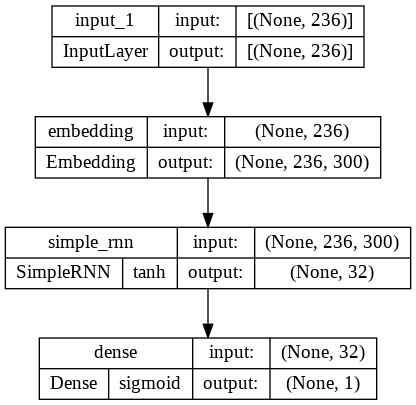

In [ ]:
plot_model(baseline, to_file = 'Baseline_RNN.png', show_shapes=True,  show_layer_activations=True)

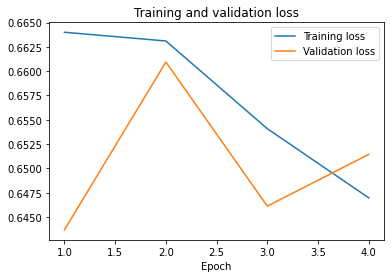

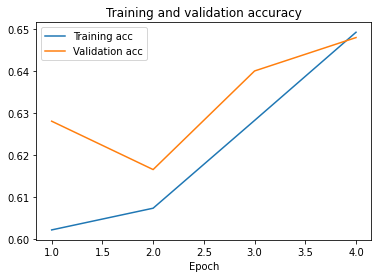

In [ ]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss,  label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    

    plt.figure()
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()
    
plot_history(history)

In [ ]:
# Evaluate on test model: threshod = 0.5

best_baseline = load_model('./models/Baseline_RNN/weights-improvement- 1-0.6280.hdf5')

y_pred_baseline = best_baseline.predict(X_test)
y_hat_baseline = np.where(y_pred_baseline > 0.5, 1, 0)
print('The prediction accuracy is: ', np.sum(y_hat_baseline.ravel() == y_test.ravel())/len(y_test))


820/820 [==============================] - 20s 24ms/step
The prediction accuracy is:  0.6254765899039195


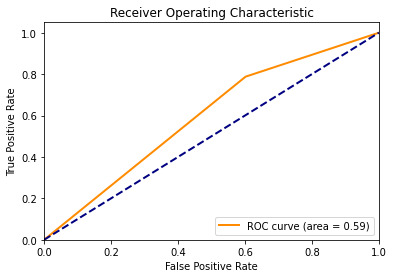

In [ ]:
# Plot the Area Under the Curve

fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_hat_baseline)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.40      0.47     10923
           1       0.65      0.79      0.71     15305

    accuracy                           0.63     26228
   macro avg       0.61      0.59      0.59     26228
weighted avg       0.62      0.63      0.61     26228



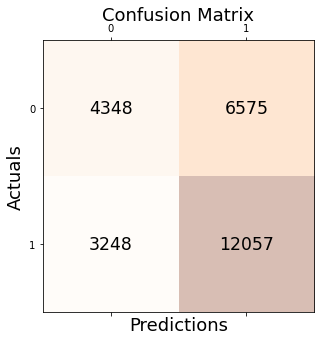

In [ ]:
# Plot confusion matrix and scores

print(classification_report(y_test, y_hat_baseline))

conf_matrix = confusion_matrix(y_test, y_hat_baseline)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# save training data
training_res = pd.DataFrame(columns=['epoch', 'acc', 'val_acc', 'loss', 'val_loss'])
training_res['acc'] = history.history['accuracy']
training_res['val_acc'] = history.history['val_accuracy']
training_res['loss'] = history.history['loss']
training_res['val_loss'] = history.history['val_loss'] 
training_res['epoch'] = range(1, len(training_res['acc']) + 1)
training_res.to_csv('training_res_baseline_RNN.csv',index = False, encoding = 'utf-8')